In [9]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
!pip install optuna
import optuna

In [10]:
df = pd.read_csv(r'winequality-red.csv',sep=';')
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [11]:
X=df.drop('quality', axis=1)
y=df['quality']
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2,random_state=42)

# Pipeline Preprocessing

In [12]:
numerical_features= X.select_dtypes(include=['int64', 'float64']).columns
categorical_features= X.select_dtypes(include=['object']).columns
print("Categorical Features:", categorical_features)
print("Numerical Features:", numerical_features)

numerical_preprocessor=Pipeline(steps=[('imputer', SimpleImputer(missing_values=np.nan,strategy='mean')), 
                                       ('scaler', StandardScaler())])
#transformers = [("numerical", numerical_preprocessor, numerical_features)]
#if len(categorical_features) > 0:
 #   categorical_preprocessor = Pipeline(steps=[
  #      ("imputation_constant", SimpleImputer(fill_value="missing", strategy="constant")),
   #     ("onehot", OneHotEncoder(handle_unknown="ignore"))
    #])
    #transformers.append(("categorical", categorical_preprocessor, categorical_features))


categorical_preprocessor= Pipeline(steps=[('imputer', SimpleImputer(fill_value="missing",strategy="most_frequent")),
                                         ('onehot', OneHotEncoder(handle_unknown="ignore"))])

Categorical Features: Index([], dtype='object')
Numerical Features: Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')


In [13]:
preprocessor= ColumnTransformer(transformers= [("cat", categorical_preprocessor, categorical_features),
                                ("num", numerical_preprocessor, numerical_features)])
preprocessor
#preprocessor = ColumnTransformer(transformers=transformers)
#preprocessor

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index([], dtype='object')),
                                ('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object'))])

In [35]:
#def objective(X_train, y_train, X_test, y_test, **params):
 #   classifier_type = params.pop('classifier_type')
 
#if classifier_type == 'RandomForest':
 #       classifier = RandomForestClassifier(**params)
#elif classifier_type == 'GradientBoosting':
        #classifier = GradientBoostingClassifier(**params)
 

accuracy obtained: 0.64375


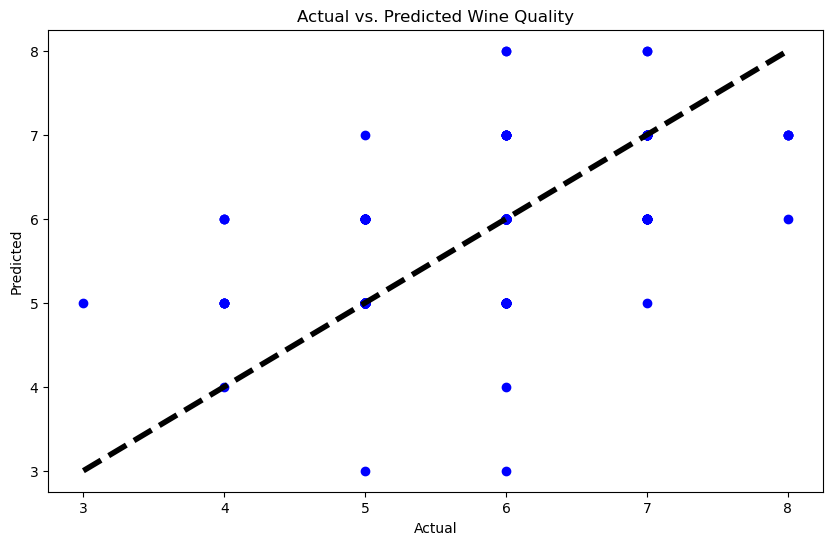

In [20]:
def objective(trial):
    classifier_name = trial.suggest_categorical('classifier', ['RandomForest', 'SVM'])
    if classifier_name == 'RandomForest':
        n_estimators = trial.suggest_int('n_estimators', 100, 200, step=100)
        max_depth = trial.suggest_int('max_depth', 2, 25, log= True)
        clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    else:
        C = trial.suggest_loguniform('C', 0.0001, 1000)
        gamma = trial.suggest_loguniform('gamma', 0.0001, 1000)
        clf = SVC(C=C, gamma=gamma, random_state=42)
#create pipeline
#pipeline=Pipeline([('preprocessor', preprocessor), ('classifier', RandomForestClassifier())])
pipeline=Pipeline(steps=[('preprocessor', preprocessor), ('classifier', GradientBoostingClassifier())])
#pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           #     ('classifier', clf)])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("accuracy obtained:",accuracy)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4) 
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Wine Quality')
plt.show()

In [21]:
# parameter grid for GridSearchCV
param_grid = [
    {'classifier': [RandomForestClassifier(random_state=42)],
     'classifier__n_estimators': [100, 200, 300,400,500,600],
     'classifier__max_depth': [None, 2, 3,5,12,30],
     'preprocessor__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
     'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]},
    {'classifier': [SVC(random_state=42)],
     'classifier__C': [0.1, 1, 10],
     'classifier__gamma': [0.001, 0.01, 0.1],
     'preprocessor__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
     'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]}
]

#  GridSearchCV 
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)


In [22]:
# Fitting GridSearchCV
grid_search.fit(X_train, y_train)

# best score and the best parameters
print("Accuracy: {:.2f}".format(grid_search.best_score_))
print("Best Parameters obtained through grid search:", grid_search.best_params_)

# Evaluating on test data using the best parameters found
best_pipeline = grid_search.best_estimator_
y_pred = best_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Accuracy: 0.69
Best Parameters obtained through grid search: {'classifier': RandomForestClassifier(n_estimators=500, random_state=42), 'classifier__max_depth': None, 'classifier__n_estimators': 500, 'preprocessor__num__imputer__strategy': 'mean', 'preprocessor__num__scaler': StandardScaler()}
Accuracy: 0.65


[I 2024-04-29 13:16:42,943] A new study created in memory with name: no-name-00c80058-c665-42a8-94f4-7f6c6ba7226a
[I 2024-04-29 13:16:43,891] Trial 0 finished with value: 0.55625 and parameters: {'n_estimators': 500, 'max_depth': 3}. Best is trial 0 with value: 0.55625.
[I 2024-04-29 13:16:44,798] Trial 1 finished with value: 0.659375 and parameters: {'n_estimators': 200, 'max_depth': 11}. Best is trial 1 with value: 0.659375.
[I 2024-04-29 13:16:45,324] Trial 2 finished with value: 0.65625 and parameters: {'n_estimators': 100, 'max_depth': 22}. Best is trial 1 with value: 0.659375.
[I 2024-04-29 13:16:46,214] Trial 3 finished with value: 0.55625 and parameters: {'n_estimators': 500, 'max_depth': 3}. Best is trial 1 with value: 0.659375.
[I 2024-04-29 13:16:48,139] Trial 4 finished with value: 0.621875 and parameters: {'n_estimators': 500, 'max_depth': 9}. Best is trial 1 with value: 0.659375.
[I 2024-04-29 13:16:48,901] Trial 5 finished with value: 0.546875 and parameters: {'n_estimat

Best Parameters obtained: {'n_estimators': 200, 'max_depth': 15}
Accuracy: 0.671875


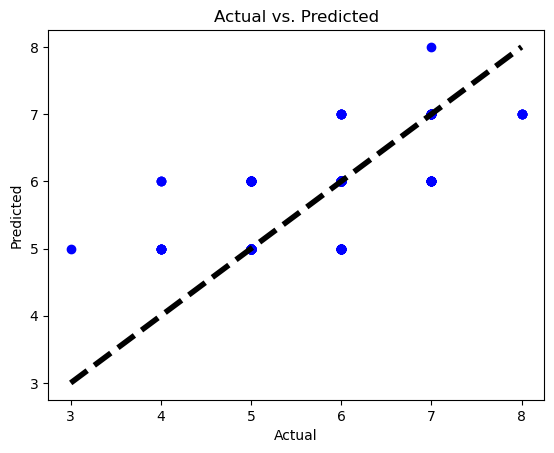

In [27]:
# Define objective function for Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500, step=100)
    max_depth = trial.suggest_int('max_depth', 2, 25, log=True)
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', clf)])
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    #print("before accuracy:", accuracy)
    return accuracy

# Bayesian optimization with Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# best hyperparameters are obtained in this step
best_params = study.best_params

# Training the final model with the best hyperparameters
best_clf = RandomForestClassifier(**best_params, random_state=42)
final_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', best_clf)])
final_pipeline.fit(X_train, y_train)

# Evaluating the best model on the test set
y_pred1 = final_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred1)
print("Best Parameters obtained:", best_params)
print("Accuracy:", accuracy)
plt.scatter(y_test, y_pred1, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4) 
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()



####References
##https://youtu.be/jzKSAeJpC6s?si=ZHYQ6X_IQVeXvWh6
##https://youtu.be/82fPl5l0vXY?si=id4tKD40_pSwDnVR
###https://github.com/krishnaik06/Pipeline-MAchine-Learning
##https://medium.com/factset/from-jupyter-notebook-experiments-to-ml-pipelines-that-work-2c9c3ae5a3c5